In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from CustomRNN import DeepRNN

import pandas as pd
import matplotlib.pyplot as plt

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('content/reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [6]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
BATCH_SIZE = 16
EPOCHS = 12
OUTPUT_SIZE = 2
INPUT_SIZE = 128

#### Customize `Dataset` and create loaders

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

Create train loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

Create test loader

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Some helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor)

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Define model class

In [0]:
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers : list):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_layers[0])
        self.rnn = DeepRNN(hidden_layers[0], hidden_layers, nonlinearity='relu')
        self.fc = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)

        output = self.rnn(embedded)

        output = self.fc(output[-1])
        return output

#### Training function

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output = classifier(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        classifier.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print('{}/{}\tLoss: {:.5f}'.format(i * len(string), len(train_loader.dataset), total_loss / i * len(string)))

#### Testing function

In [0]:
test_acc = []

In [0]:
def test(string=None):
    if string:
        input, seq_lens, target = make_variables([string], [])

        output = classifier(input)

        pred = output.data.max(1, keepdim=True)[1]
        print('{} is {}'.format(string, pred))
        return
    
    print('\nEvaluating model...')
    correct = 0
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output = classifier(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct / test_data_size
    test_acc.append(acc)
        
    print('Test set accuracy: {}/{} ({:.2f}%)\n'.format(correct, test_data_size, acc))

#### Time for action!

#### Base RNN

In [0]:
classifier = RNNModel(INPUT_SIZE, 2, [100, 300, 500])

In [0]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
%%time
for epoch in range(1, EPOCHS+1):
    print('Epoch #{}\n{}'.format(epoch, 12*'-'))
    train()
    test()

Epoch #1
------------
1600/18750	Loss: 9.21194
3200/18750	Loss: 8.38997
4800/18750	Loss: 7.67305
6400/18750	Loss: 7.70600
8000/18750	Loss: 7.42607
9600/18750	Loss: 7.25028
11200/18750	Loss: 7.07103
12800/18750	Loss: 6.90554
14400/18750	Loss: 6.74253
16000/18750	Loss: 6.64404
17600/18750	Loss: 6.49346

Evaluating model...
Test set accuracy: 5310/6250 (84.00%)

Epoch #2
------------
1600/18750	Loss: 5.81801
3200/18750	Loss: 6.41608
4800/18750	Loss: 6.56837
6400/18750	Loss: 6.49413
8000/18750	Loss: 6.46016
9600/18750	Loss: 6.29393
11200/18750	Loss: 6.22164
12800/18750	Loss: 6.03566
14400/18750	Loss: 5.86426
16000/18750	Loss: 5.97729
17600/18750	Loss: 6.15921

Evaluating model...
Test set accuracy: 5087/6250 (81.00%)

Epoch #3
------------
1600/18750	Loss: 4.59531
3200/18750	Loss: 4.64448
4800/18750	Loss: 4.84077
6400/18750	Loss: 4.79981
8000/18750	Loss: 4.68225
9600/18750	Loss: 4.50273
11200/18750	Loss: 4.35524
12800/18750	Loss: 4.24713
14400/18750	Loss: 4.14502
16000/18750	Loss: 4.07305


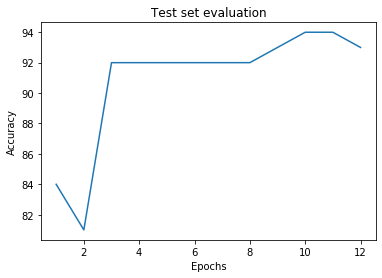

In [22]:
plt.title('Test set evaluation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(1, len(test_acc)+1), test_acc)